In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, average_precision_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

#  1. 北美

In [2]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Canada'])]
test_data = data[data['Market'] == 'United States']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Canada    419
 Name: count, dtype: int64,
 Market
 United States    895
 Name: count, dtype: int64)

In [3]:
# 分离特征和标签

X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [4]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8281622911694511 F1 Score: 0.8222105774997023 AUC: 0.9586467428545453 prAUC: 0.8759884003387338
Test Results: Accuracy: 0.5731843575418994 F1 Score: 0.5545357904676894 AUC: 0.8565767599269184 prAUC: 0.6317389670156623


In [5]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=2000,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9093078758949881 F1 Score: 0.9075082040108675 AUC: 0.9893212016313605 prAUC: 0.9676003582494636
Test Results: Accuracy: 0.6022346368715084 F1 Score: 0.5885901721432665 AUC: 0.8561819383971143 prAUC: 0.6125302513989653


In [6]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.847255369928401 F1 Score: 0.8407934080141105 AUC: 0.9628802949264981 prAUC: 0.886595379165497
Test Results: Accuracy: 0.5966480446927375 F1 Score: 0.5819356459069912 AUC: 0.8590295966377731 prAUC: 0.6317771606888831


In [7]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.847255369928401 F1 Score: 0.8407934080141105 AUC: 0.9628802949264981 prAUC: 0.886595379165497
Test Results: Accuracy: 0.5966480446927375 F1 Score: 0.5819356459069912 AUC: 0.8590295966377731 prAUC: 0.6317771606888831


In [8]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8769744131561081, 'gamma': 1, 'learning_rate': 0.178807585701814, 'max_depth': 15, 'min_child_weight': 6, 'n_estimators': 671, 'reg_alpha': 1, 'reg_lambda': 4, 'subsample': 0.681814801189647}

Train Results: Accuracy: 0.8758949880668258 F1 Score: 0.8708921105952017 AUC: 0.9797260339683712 prAUC: 0.9298460165505613
Test Results: Accuracy: 0.6089385474860335 F1 Score: 0.5989629747095421 AUC: 0.8557405479950526 prAUC: 0.6068709736022965


In [22]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=15,                # 降低树的深度
    n_estimators=1500,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9069212410501193 F1 Score: 0.9046350209738223 AUC: 0.98834727628488 prAUC: 0.9624710629586577
Test Results: Accuracy: 0.6033519553072626 F1 Score: 0.5912215978095258 AUC: 0.8603547654837851 prAUC: 0.6211631145827263


## 预测加拿大

In [23]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['United States'])]
test_data = data[data['Market'] == 'Canada']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 United States    895
 Name: count, dtype: int64,
 Market
 Canada    419
 Name: count, dtype: int64)

In [24]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [25]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7955307262569833 F1 Score: 0.794127051577696 AUC: 0.9473262125255908 prAUC: 0.8637667994216599
Test Results: Accuracy: 0.60381861575179 F1 Score: 0.5964463156762287 AUC: 0.8460507807044446 prAUC: 0.5739574559536912


In [26]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=30,                # 降低树的深度
    n_estimators=500,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8815642458100559 F1 Score: 0.880700106330115 AUC: 0.9798882058799405 prAUC: 0.9428678292731227
Test Results: Accuracy: 0.6062052505966588 F1 Score: 0.6007890083420375 AUC: 0.8472204794894246 prAUC: 0.5801436699933329


In [27]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.8089385474860336 F1 Score: 0.8072947578686817 AUC: 0.9496028700842531 prAUC: 0.8649635163048249
Test Results: Accuracy: 0.5894988066825776 F1 Score: 0.5828300949408537 AUC: 0.8449268881222296 prAUC: 0.5738391425681246


In [28]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1200, 'max_depth': 20, 'learning_rate': 0.05, 'lambda': 3, 'gamma': 3, 'alpha': 1}

Train Results: Accuracy: 0.7743016759776536 F1 Score: 0.7720014588703592 AUC: 0.9335315302659687 prAUC: 0.8250672298969942
Test Results: Accuracy: 0.6181384248210023 F1 Score: 0.6060809421288171 AUC: 0.8466912179728571 prAUC: 0.5701125982175144


In [38]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=20,                # 降低树的深度
    n_estimators=1500,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.6,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8804469273743016 F1 Score: 0.8799952000666741 AUC: 0.9815470220163544 prAUC: 0.948062193109591
Test Results: Accuracy: 0.630071599045346 F1 Score: 0.6234880310290501 AUC: 0.8508116961064394 prAUC: 0.589876713638199


In [29]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.9757995766256756, 'gamma': 3, 'learning_rate': 0.3089499894055426, 'max_depth': 12, 'min_child_weight': 7, 'n_estimators': 451, 'reg_alpha': 1, 'reg_lambda': 8, 'subsample': 0.9222669243390758}

Train Results: Accuracy: 0.7664804469273743 F1 Score: 0.7605202248516086 AUC: 0.9305831820064037 prAUC: 0.8179390144754165
Test Results: Accuracy: 0.6014319809069213 F1 Score: 0.5854668333522749 AUC: 0.8340837872943464 prAUC: 0.5525806474950415


# 2. 大洋洲

## 2.1 预测澳洲

In [2]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['New Zealand'])]
test_data = data[data['Market'] == 'Australia']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 New Zealand    58
 Name: count, dtype: int64,
 Market
 Australia    396
 Name: count, dtype: int64)

In [3]:
# 分离特征和标签

X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [41]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7413793103448276 F1 Score: 0.6887429301222404 AUC: 0.9482187583821595 prAUC: 0.7567285049052173
Test Results: Accuracy: 0.43686868686868685 F1 Score: 0.32711905698918686 AUC: 0.6537722371535883 prAUC: 0.40149502418056693


In [4]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7758620689655172 F1 Score: 0.7248363160192056 AUC: 0.9795245062908107 prAUC: 0.969013624500934
Test Results: Accuracy: 0.4696969696969697 F1 Score: 0.39057221279688836 AUC: 0.653443000487556 prAUC: 0.4093417238436895


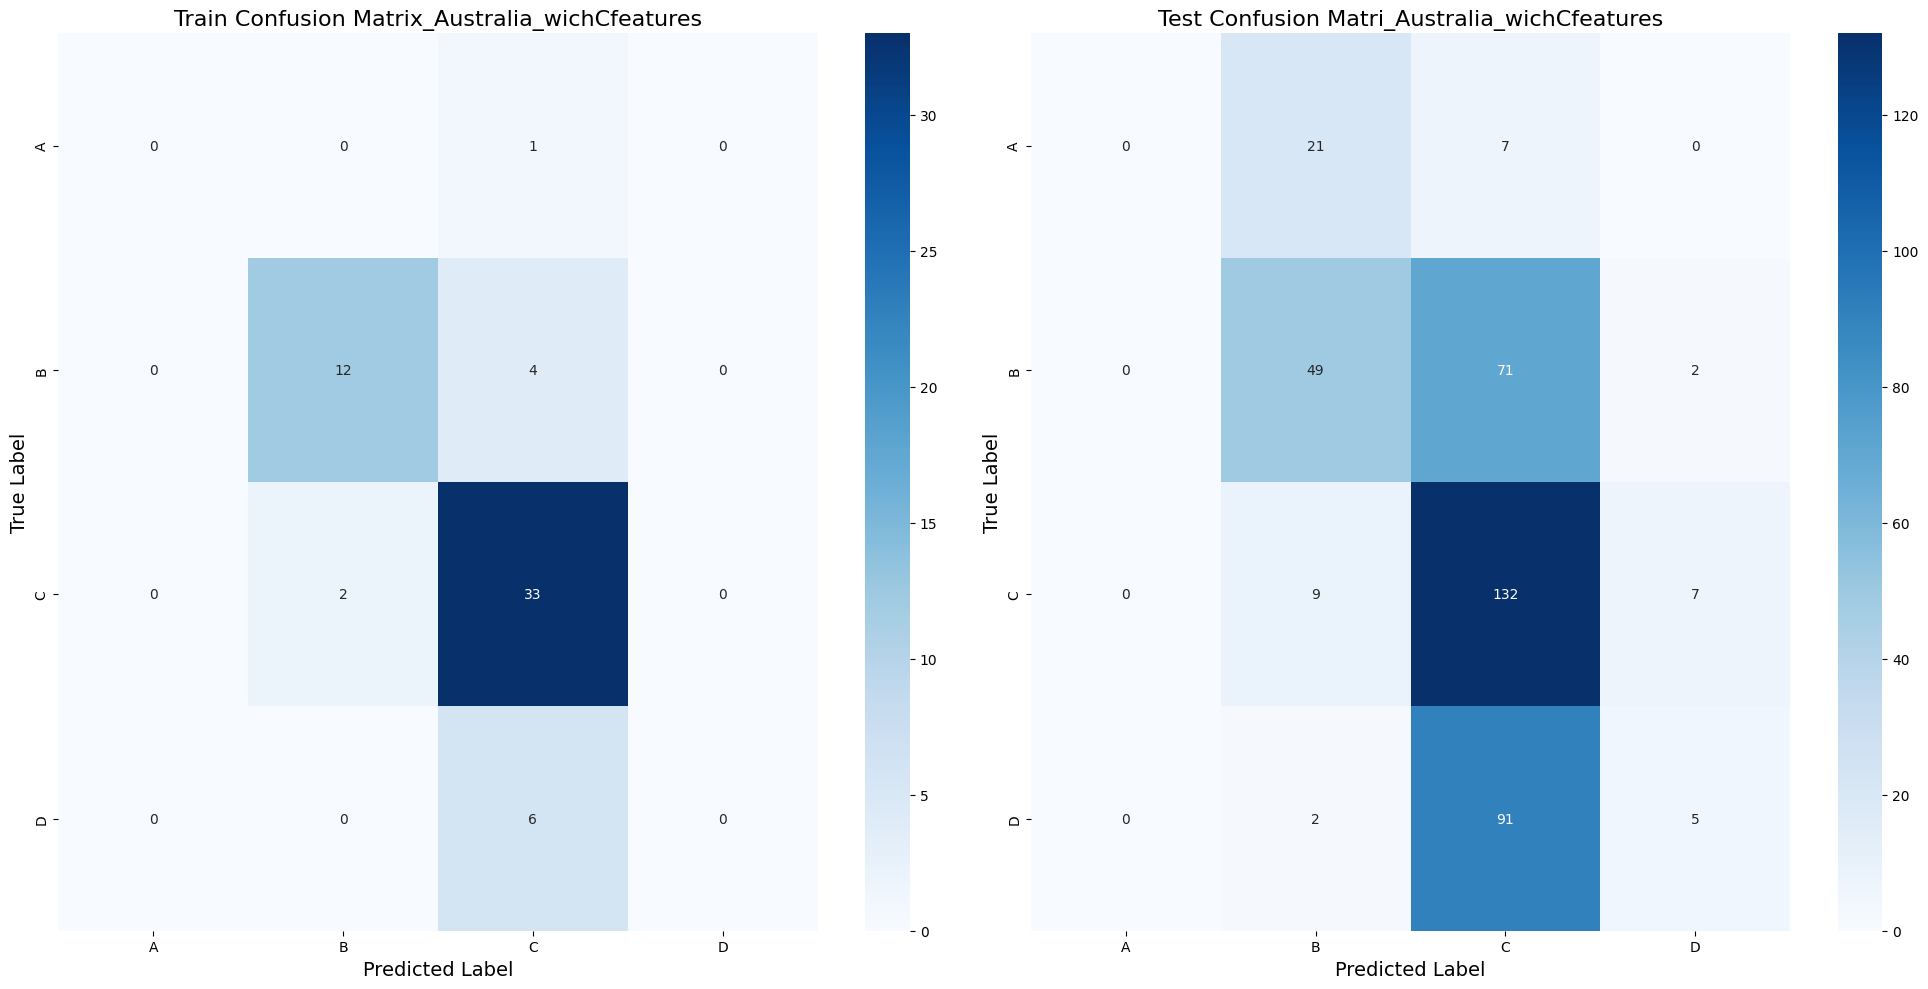

In [5]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# 绘制训练集和测试集的混淆矩阵
y_train_pred = tuned_xgb_model.predict(X_train)
y_test_pred = tuned_xgb_model.predict(X_test)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(20, 10))

# 训练集混淆矩阵
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Train Confusion Matrix_Australia_wichCfeatures', fontsize=16)

# 测试集混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Test Confusion Matri_Australia_wichCfeatures', fontsize=16)

plt.tight_layout()
plt.show()


SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (58, 92, 4)


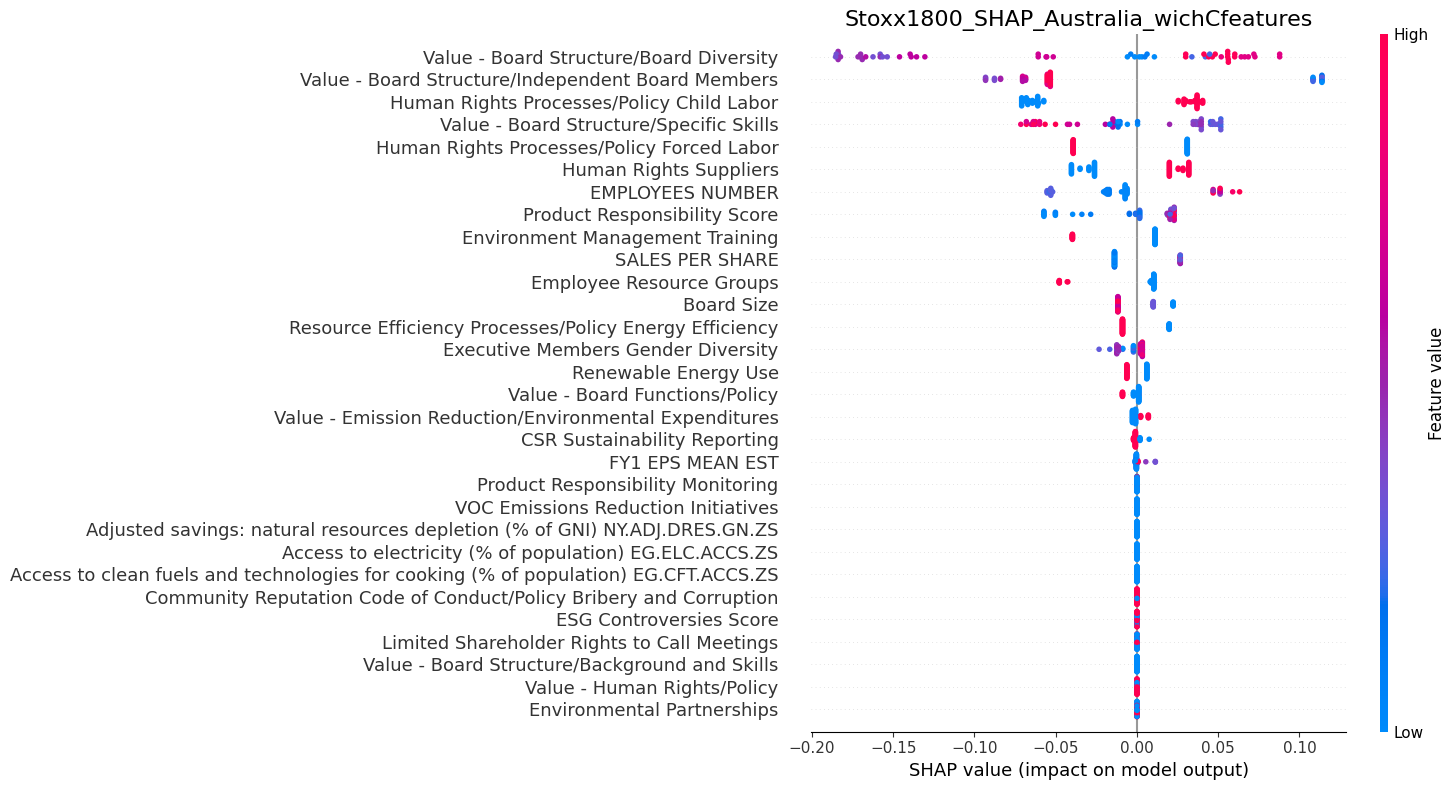

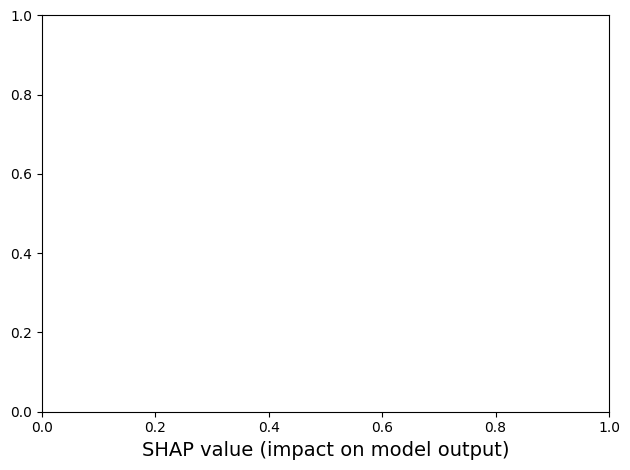

In [ ]:
import shap
import matplotlib.pyplot as plt

# 使用 SHAP 解释器计算 SHAP 值
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# 输出 shap_values 的类型和形状
print("SHAP values type:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values shape (for each class):", [sv.shape for sv in shap_values])
else:
    print("SHAP values shape:", shap_values.shape)

# 确保 feature_names 被定义
feature_names = X_train.columns

# 绘制总体 SHAP summary plot
# 将 SHAP 值按类别进行平均，得到总体 SHAP 值
shap_values_mean = shap_values.mean(axis=2)

plt.figure(figsize=(15, 8))  # 增大图形尺寸
plt.title("Stoxx1800_SHAP_Australia_wichCfeatures", fontsize=16)  # 增大标题字体
shap.summary_plot(shap_values_mean, X_train, feature_names=feature_names, max_display=30, plot_size=(15, 8))
plt.xlabel("SHAP value (impact on model output)", fontsize=14)  # 增大x轴标签字体
plt.tight_layout()  # 自动调整布局
plt.show()  # 显示图形

In [43]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/Applications/hello/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/Applications/hello/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
243 fits failed out of a total of 729.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
243 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/hello/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/hello/.venv/lib/python3.11/site-packages/xgboost/core.p

Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.7241379310344828 F1 Score: 0.6650574712643678 AUC: 0.9431077825206831 prAUC: 0.7383401746188338
Test Results: Accuracy: 0.42676767676767674 F1 Score: 0.3063305007749452 AUC: 0.6540306695610867 prAUC: 0.40811702738166294


In [44]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Applications/hello/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/Applications/hello/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/hello/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/hello/.venv/lib/python3.11/site-packages/xgboost/core.py",

Best Parameters: {'n_estimators': 1500, 'max_depth': 30, 'learning_rate': 0.2, 'lambda': 2, 'gamma': 3, 'alpha': 3}

Train Results: Accuracy: 0.603448275862069 F1 Score: 0.45420837968112715 AUC: 0.6657700637463223 prAUC: 0.3346746715927751
Test Results: Accuracy: 0.37373737373737376 F1 Score: 0.20335710041592392 AUC: 0.5437237284702298 prAUC: 0.28740415461955415


In [45]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Applications/hello/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/Applications/hello/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/hello/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/hello/.venv/lib/python3.11/site-packages/xgboost/core.py"

Best Parameters: {'colsample_bytree': 0.749816047538945, 'gamma': 4, 'learning_rate': 0.10171739493308189, 'max_depth': 12, 'min_child_weight': 5, 'n_estimators': 321, 'reg_alpha': 3, 'reg_lambda': 7, 'subsample': 0.5290418060840998}

Train Results: Accuracy: 0.603448275862069 F1 Score: 0.45420837968112715 AUC: 0.5 prAUC: 0.25
Test Results: Accuracy: 0.37373737373737376 F1 Score: 0.20335710041592392 AUC: 0.5 prAUC: 0.25


## 2.2 预测新西兰

In [2]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Australia'])]
test_data = data[data['Market'] == 'New Zealand']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Australia    396
 Name: Market, dtype: int64,
 New Zealand    58
 Name: Market, dtype: int64)

In [3]:
# 分离特征和标签

X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [24]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7803030303030303 F1 Score: 0.7806191021244785 AUC: 0.9474802099680394 prAUC: 0.8723807236759584
Test Results: Accuracy: 0.7413793103448276 F1 Score: 0.7283176593521421 AUC: 0.8126213841459837 prAUC: 0.5190849574054472


In [4]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8939393939393939 F1 Score: 0.894289532214135 AUC: 0.9846832486509114 prAUC: 0.959296689636938
Test Results: Accuracy: 0.7758620689655172 F1 Score: 0.7607202590655135 AUC: 0.7890987004509602 prAUC: 0.5303012231189043


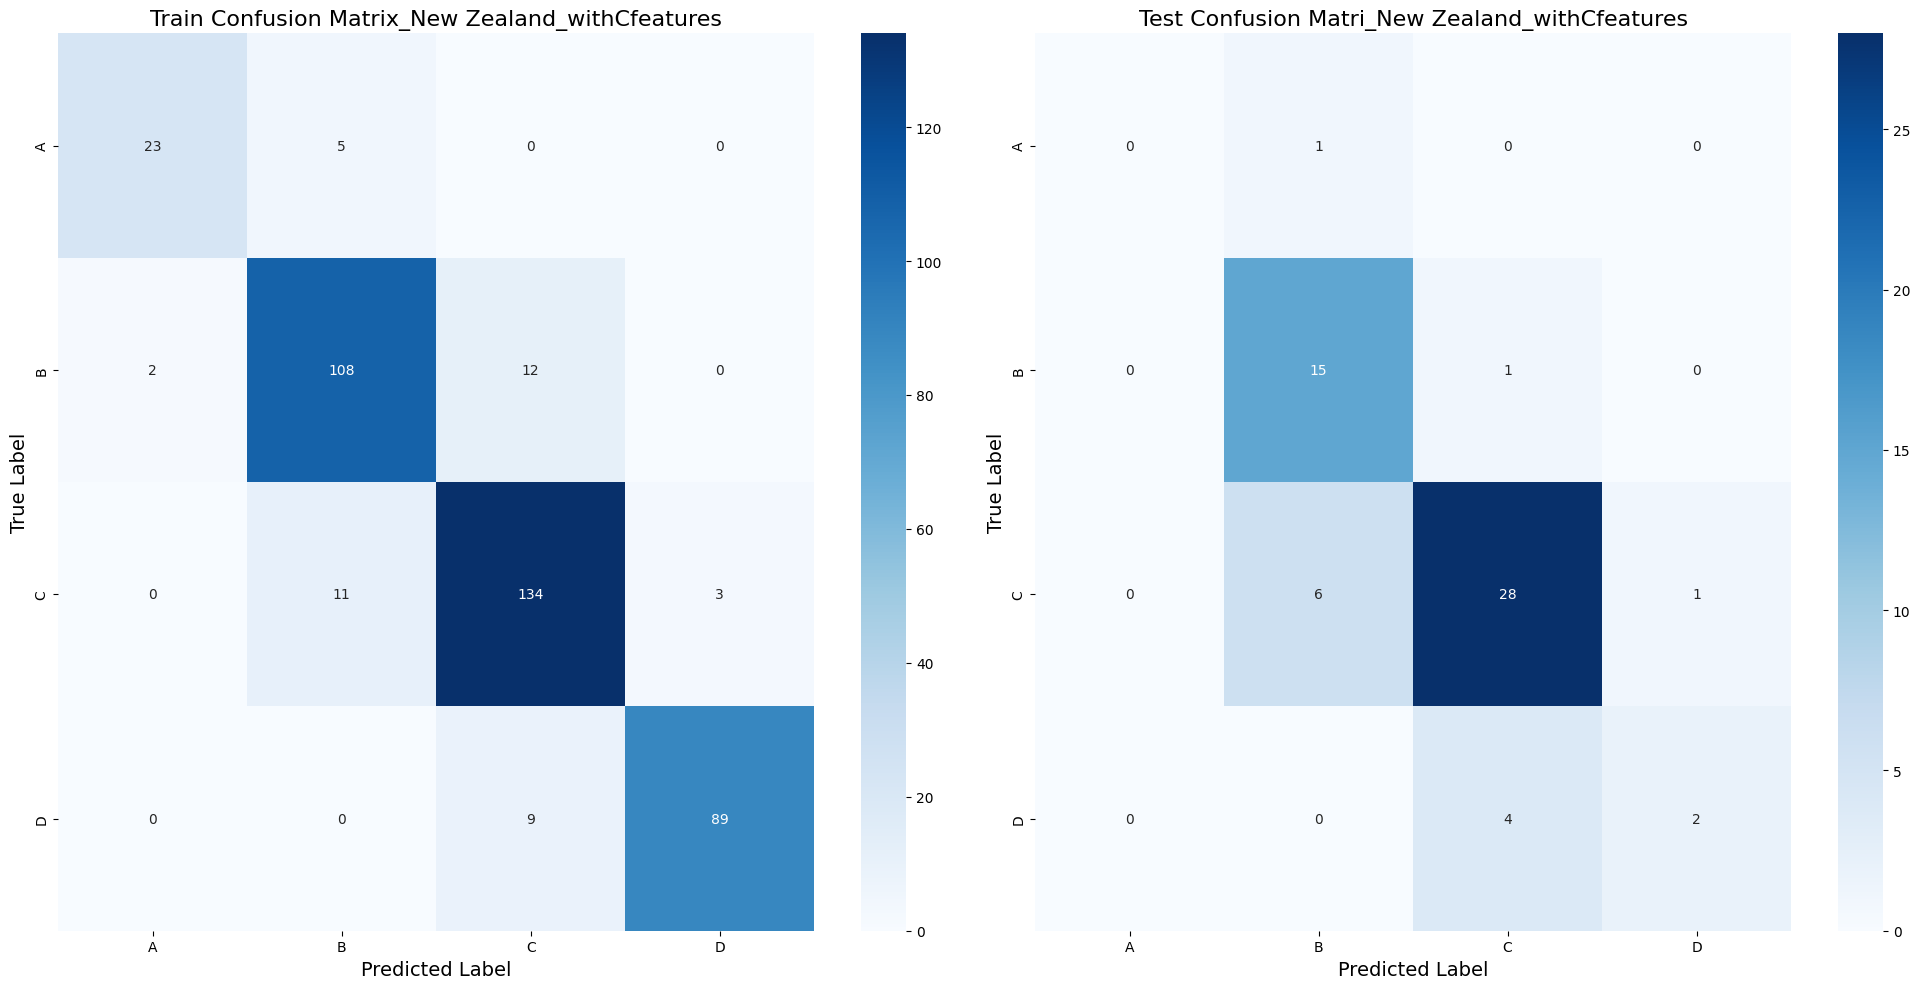

In [5]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# 绘制训练集和测试集的混淆矩阵
y_train_pred = tuned_xgb_model.predict(X_train)
y_test_pred = tuned_xgb_model.predict(X_test)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(20, 10))

# 训练集混淆矩阵
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Train Confusion Matrix_New Zealand_withCfeatures', fontsize=16)

# 测试集混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Test Confusion Matri_New Zealand_withCfeatures', fontsize=16)

plt.tight_layout()
plt.show()


SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (396, 92, 4)


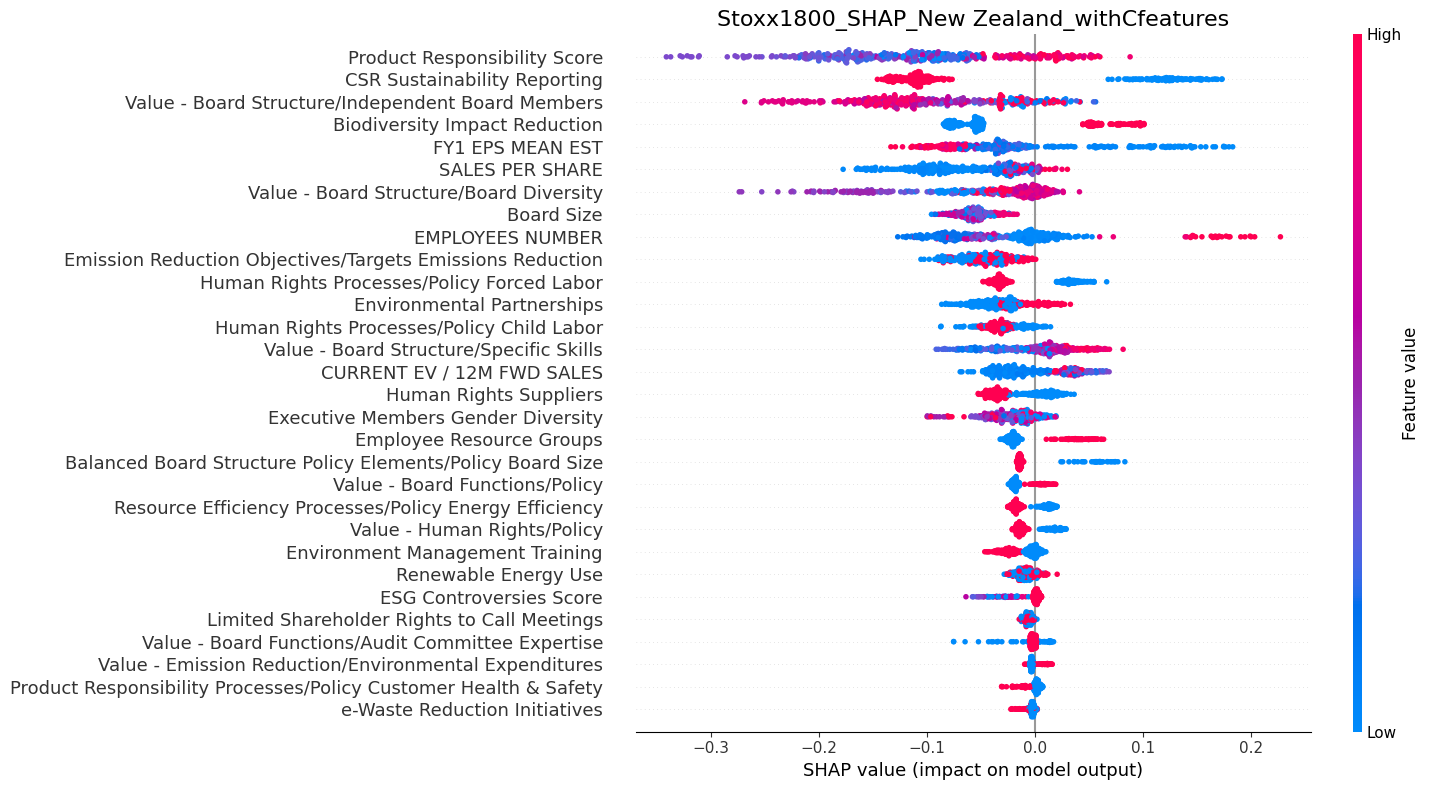

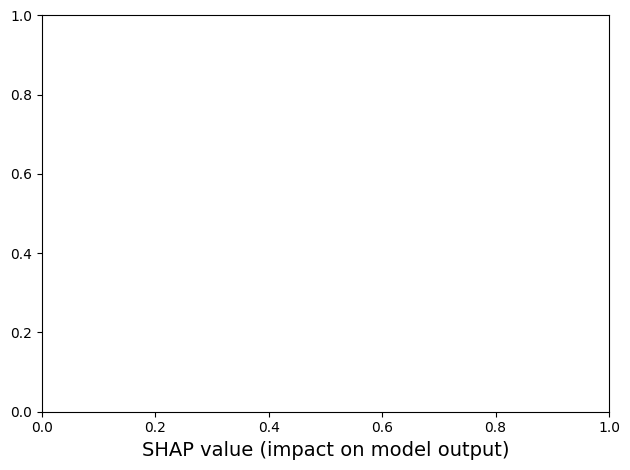

In [6]:
import shap
import matplotlib.pyplot as plt

# 使用 SHAP 解释器计算 SHAP 值
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# 输出 shap_values 的类型和形状
print("SHAP values type:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values shape (for each class):", [sv.shape for sv in shap_values])
else:
    print("SHAP values shape:", shap_values.shape)

# 确保 feature_names 被定义
feature_names = X_train.columns

# 绘制总体 SHAP summary plot
# 将 SHAP 值按类别进行平均，得到总体 SHAP 值
shap_values_mean = shap_values.mean(axis=2)

plt.figure(figsize=(15, 8))  # 增大图形尺寸
plt.title("Stoxx1800_SHAP_New Zealand_withCfeatures", fontsize=16)  # 增大标题字体
shap.summary_plot(shap_values_mean, X_train, feature_names=feature_names, max_display=30, plot_size=(15, 8))
plt.xlabel("SHAP value (impact on model output)", fontsize=14)  # 增大x轴标签字体
plt.tight_layout()  # 自动调整布局
plt.show()  # 显示图形

In [51]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 3, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.7853535353535354 F1 Score: 0.7853261875806504 AUC: 0.9463726325239973 prAUC: 0.8696634392920102
Test Results: Accuracy: 0.7241379310344828 F1 Score: 0.7124668435013262 AUC: 0.8144232733799381 prAUC: 0.5244993647902496


In [52]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.1, 'lambda': 1, 'gamma': 2, 'alpha': 2}

Train Results: Accuracy: 0.7651515151515151 F1 Score: 0.7652499814622712 AUC: 0.9366920195862342 prAUC: 0.8466499007508245
Test Results: Accuracy: 0.6896551724137931 F1 Score: 0.6799939617433309 AUC: 0.8178766313777756 prAUC: 0.5142974049401652


In [53]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.9887128330883843, 'gamma': 3, 'learning_rate': 0.1334380314193006, 'max_depth': 11, 'min_child_weight': 2, 'n_estimators': 586, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.6424202471887338}

Train Results: Accuracy: 0.7348484848484849 F1 Score: 0.7354890529904277 AUC: 0.9259752449973326 prAUC: 0.8228976966383916
Test Results: Accuracy: 0.6896551724137931 F1 Score: 0.6800808760438701 AUC: 0.8535015423173318 prAUC: 0.540411344199059


# 3. 综合起来看

## 3.1 预测澳洲

In [32]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['New Zealand','United States','Canada'])]
test_data = data[data['Market'] == 'Australia']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 United States    895
 Canada           419
 New Zealand       58
 Name: count, dtype: int64,
 Market
 Australia    396
 Name: count, dtype: int64)

In [33]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)
# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [56]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8010204081632653 F1 Score: 0.7991570213088446 AUC: 0.9509114186224816 prAUC: 0.854799485551544
Test Results: Accuracy: 0.6540404040404041 F1 Score: 0.6424042794570386 AUC: 0.8794702120462841 prAUC: 0.6881837828240431


In [34]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=2,               # L1 正则化
    reg_lambda=4,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth=18,                # 降低树的深度
    n_estimators=1500,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.8,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7886297376093294 F1 Score: 0.7857297231390034 AUC: 0.9456316998835788 prAUC: 0.8380346298945486
Test Results: Accuracy: 0.6767676767676768 F1 Score: 0.6691420072015012 AUC: 0.8806955455377639 prAUC: 0.6969868705172703


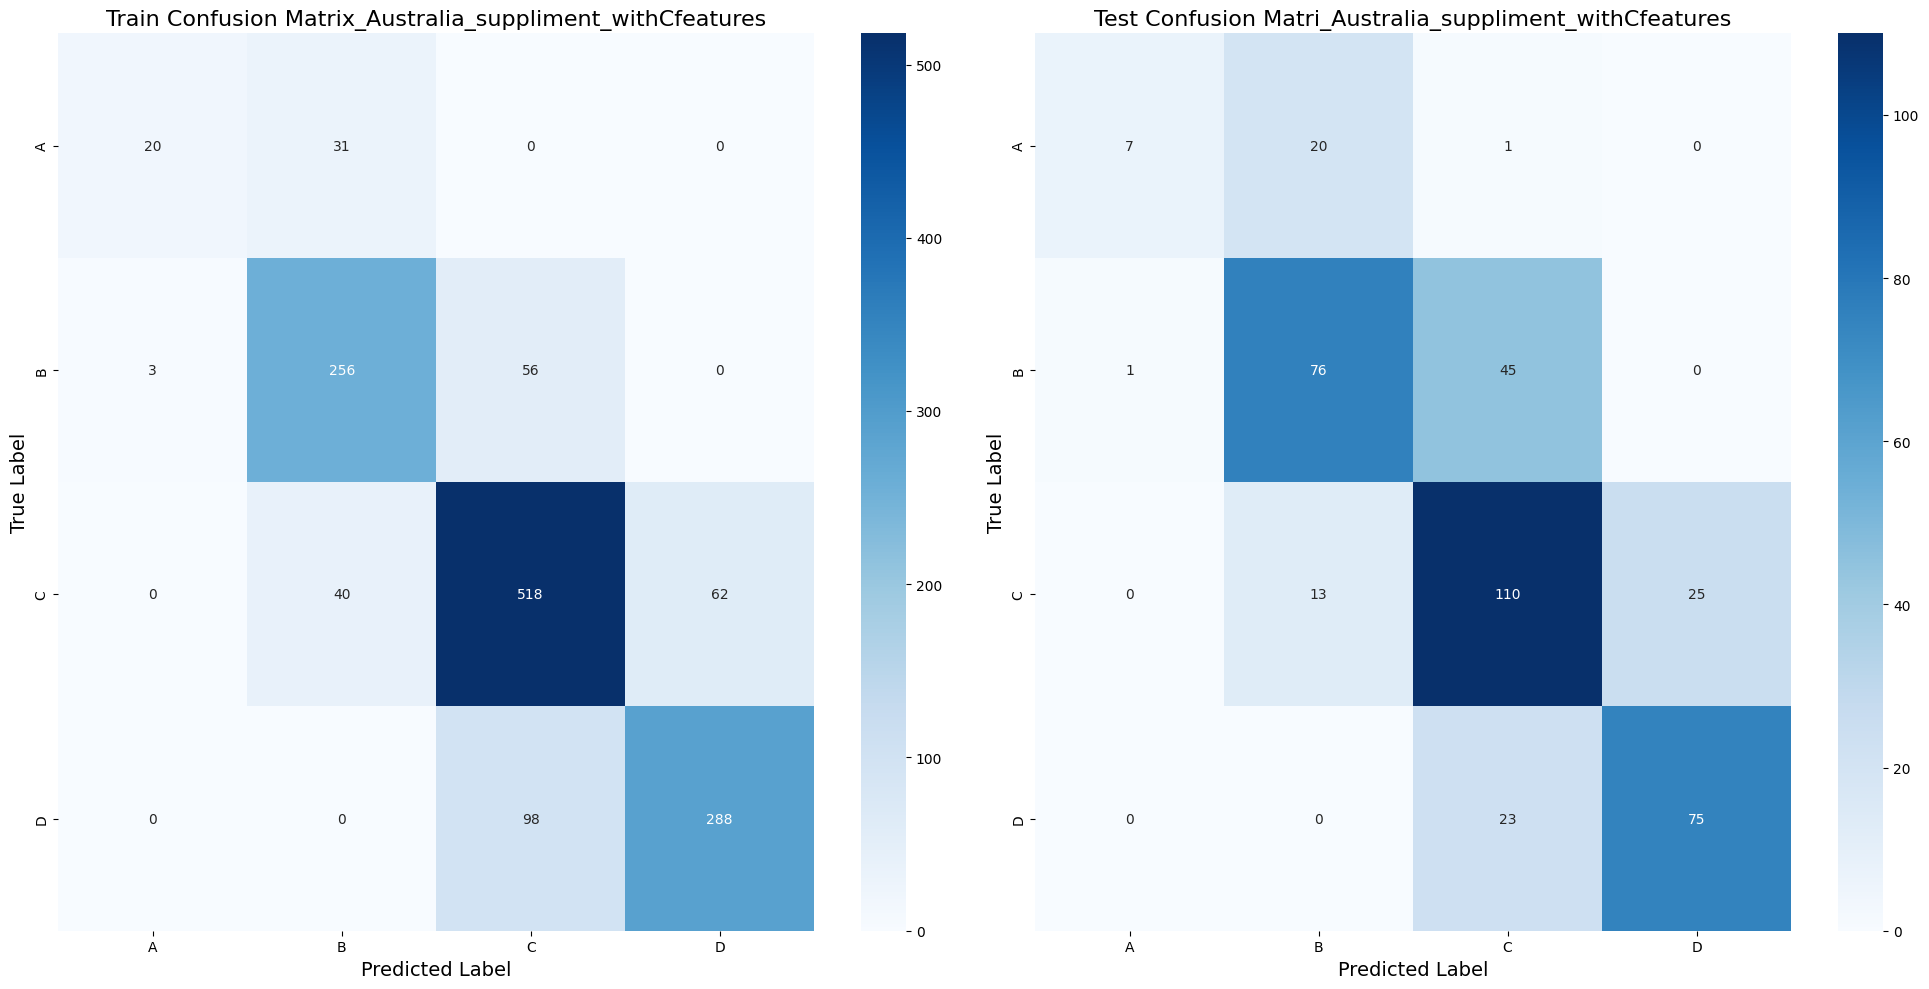

In [35]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# 绘制训练集和测试集的混淆矩阵
y_train_pred = tuned_xgb_model.predict(X_train)
y_test_pred = tuned_xgb_model.predict(X_test)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(20, 10))

# 训练集混淆矩阵
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Train Confusion Matrix_Australia_suppliment_withCfeatures', fontsize=16)

# 测试集混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Test Confusion Matri_Australia_suppliment_withCfeatures', fontsize=16)

plt.tight_layout()
plt.show()


SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (1372, 92, 4)


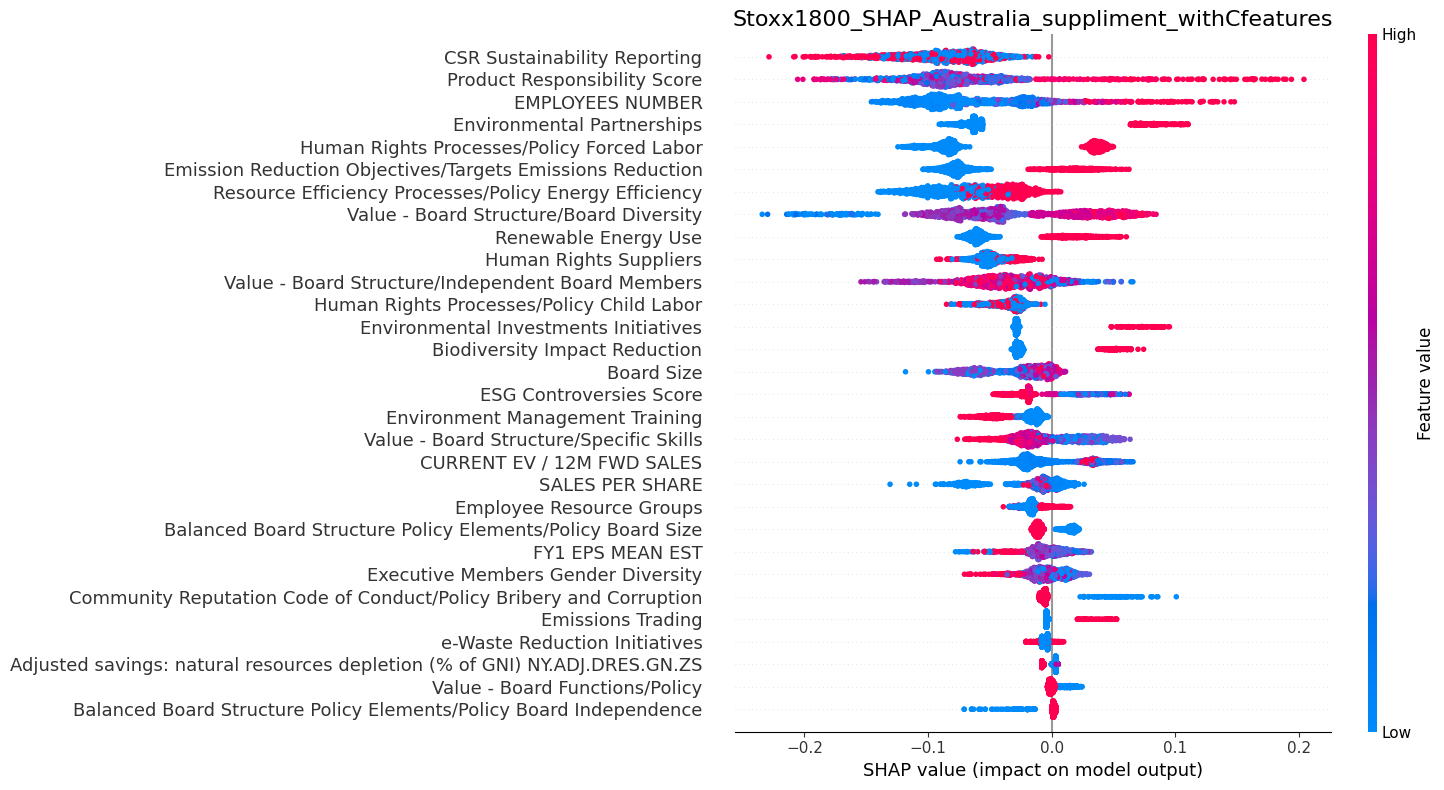

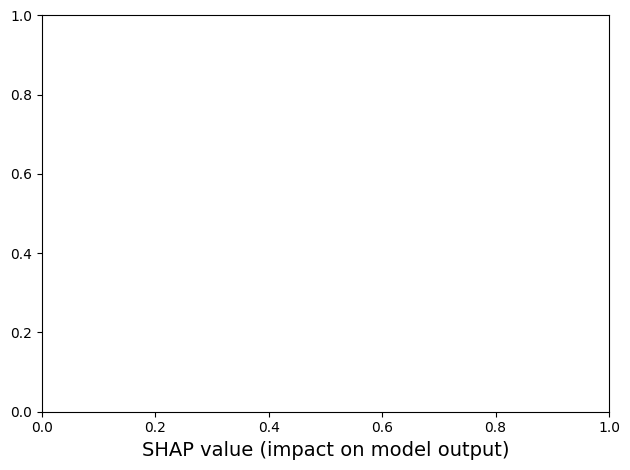

In [36]:
import shap
import matplotlib.pyplot as plt

# 使用 SHAP 解释器计算 SHAP 值
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# 输出 shap_values 的类型和形状
print("SHAP values type:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values shape (for each class):", [sv.shape for sv in shap_values])
else:
    print("SHAP values shape:", shap_values.shape)

# 确保 feature_names 被定义
feature_names = X_train.columns

# 绘制总体 SHAP summary plot
# 将 SHAP 值按类别进行平均，得到总体 SHAP 值
shap_values_mean = shap_values.mean(axis=2)

plt.figure(figsize=(15, 8))  # 增大图形尺寸
plt.title("Stoxx1800_SHAP_Australia_suppliment_withCfeatures", fontsize=16)  # 增大标题字体
shap.summary_plot(shap_values_mean, X_train, feature_names=feature_names, max_display=30, plot_size=(15, 8))
plt.xlabel("SHAP value (impact on model output)", fontsize=14)  # 增大x轴标签字体
plt.tight_layout()  # 自动调整布局
plt.show()  # 显示图形

In [58]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 2, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.793002915451895 F1 Score: 0.7901084079811825 AUC: 0.9465440641199232 prAUC: 0.838839000377262
Test Results: Accuracy: 0.6742424242424242 F1 Score: 0.6670509462094032 AUC: 0.8806230433910078 prAUC: 0.7015143160075148


In [59]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1000, 'max_depth': 25, 'learning_rate': 0.2, 'lambda': 3, 'gamma': 1, 'alpha': 3}

Train Results: Accuracy: 0.8279883381924198 F1 Score: 0.8262013319214297 AUC: 0.964036581689629 prAUC: 0.8888560645219357
Test Results: Accuracy: 0.6742424242424242 F1 Score: 0.663594064792776 AUC: 0.8795313177940285 prAUC: 0.6883062359509452


In [60]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.7016654596278955, 'gamma': 1, 'learning_rate': 0.44868653596397773, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 592, 'reg_alpha': 3, 'reg_lambda': 6, 'subsample': 0.6797455756098776}

Train Results: Accuracy: 0.8170553935860059 F1 Score: 0.8138998200737356 AUC: 0.9572789483173436 prAUC: 0.8572068587955517
Test Results: Accuracy: 0.6515151515151515 F1 Score: 0.6381940759939911 AUC: 0.8738727743831606 prAUC: 0.6812348389166898


## 3.2 预测新西兰

In [61]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['United States','Canada','Australia'])]
test_data = data[data['Market'] == 'New Zealand']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 United States    895
 Canada           419
 Australia        396
 Name: count, dtype: int64,
 Market
 New Zealand    58
 Name: count, dtype: int64)

In [62]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)
# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [63]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8011695906432749 F1 Score: 0.8002594030023912 AUC: 0.950221341752859 prAUC: 0.8614945704223744
Test Results: Accuracy: 0.7068965517241379 F1 Score: 0.6972755307490379 AUC: 0.8652294275613783 prAUC: 0.5988089320902955


In [64]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=2,               # L1 正则化
    reg_lambda=4,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth=18,                # 降低树的深度
    n_estimators=1500,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.8,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7824561403508772 F1 Score: 0.7804981434255557 AUC: 0.946590259435055 prAUC: 0.845362988524479
Test Results: Accuracy: 0.7241379310344828 F1 Score: 0.7123797458331683 AUC: 0.8637899095565 prAUC: 0.6089345378187533


In [65]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.8128654970760234 F1 Score: 0.811874866656806 AUC: 0.9547718704567347 prAUC: 0.8722078577451988
Test Results: Accuracy: 0.7241379310344828 F1 Score: 0.7131755018013382 AUC: 0.8688542269134374 prAUC: 0.6283670090883683


In [66]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1200, 'max_depth': 25, 'learning_rate': 0.2, 'lambda': 2, 'gamma': 2, 'alpha': 2}

Train Results: Accuracy: 0.7988304093567251 F1 Score: 0.7978182737135598 AUC: 0.9493244781824975 prAUC: 0.8544239597488231
Test Results: Accuracy: 0.7241379310344828 F1 Score: 0.7131755018013382 AUC: 0.8770623386434313 prAUC: 0.6171235491798107


In [67]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.9193180715867101, 'gamma': 0, 'learning_rate': 0.04547045849996383, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 342, 'reg_alpha': 4, 'reg_lambda': 2, 'subsample': 0.5469909699204345}

Train Results: Accuracy: 0.8725146198830409 F1 Score: 0.8713797460661928 AUC: 0.9801306659294513 prAUC: 0.9287048199291722
Test Results: Accuracy: 0.7413793103448276 F1 Score: 0.7375130616509926 AUC: 0.8446964243803489 prAUC: 0.6276407438759637


In [68]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=2,               # L1 正则化
    reg_lambda=4,              # L2 正则化
    gamma =0,                   # 添加 gamma 限制分裂
    max_depth=7,                # 降低树的深度
    n_estimators=1500,          # 树的数量
    learning_rate=0.04,        # 降低学习率
    subsample=0.8,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 1.0 F1 Score: 1.0 AUC: 1.0 prAUC: 1.0
Test Results: Accuracy: 0.7931034482758621 F1 Score: 0.7904000866809329 AUC: 0.8269597095791318 prAUC: 0.6194454697748135


## 3.3 预测美国

In [69]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['New Zealand','Canada','Australia'])]
test_data = data[data['Market'] == 'United States']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Canada         419
 Australia      396
 New Zealand     58
 Name: count, dtype: int64,
 Market
 United States    895
 Name: count, dtype: int64)

In [70]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)
# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [71]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8144329896907216 F1 Score: 0.8127272694318778 AUC: 0.9583975981574694 prAUC: 0.8745657419062522
Test Results: Accuracy: 0.6793296089385474 F1 Score: 0.6786944709218626 AUC: 0.8831900942277215 prAUC: 0.7022829728565052


In [72]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9175257731958762 F1 Score: 0.9169285559352944 AUC: 0.9897852740464145 prAUC: 0.968029652946049
Test Results: Accuracy: 0.6435754189944134 F1 Score: 0.6431172493457794 AUC: 0.8826192448049459 prAUC: 0.6956627088204764


In [73]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.8178694158075601 F1 Score: 0.8149307240169926 AUC: 0.960253211523943 prAUC: 0.8790931336688975
Test Results: Accuracy: 0.6703910614525139 F1 Score: 0.6696941997518151 AUC: 0.8804103531778295 prAUC: 0.6956771603353937


In [74]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1500, 'max_depth': 20, 'learning_rate': 0.05, 'lambda': 1, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.9163802978235968 F1 Score: 0.9156472721808272 AUC: 0.9899306866045656 prAUC: 0.9694973093312531
Test Results: Accuracy: 0.6525139664804469 F1 Score: 0.6522014513711546 AUC: 0.8820695737136653 prAUC: 0.6964782790676737


In [75]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8473015537351571, 'gamma': 0, 'learning_rate': 0.3378613176903711, 'max_depth': 14, 'min_child_weight': 2, 'n_estimators': 314, 'reg_alpha': 1, 'reg_lambda': 7, 'subsample': 0.5590824138108281}

Train Results: Accuracy: 1.0 F1 Score: 1.0 AUC: 1.0 prAUC: 1.0
Test Results: Accuracy: 0.6256983240223464 F1 Score: 0.6252567833732555 AUC: 0.8648250627832144 prAUC: 0.6557281714248215


## 3.4 预测加拿大

In [76]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['New Zealand','United States','Australia'])]
test_data = data[data['Market'] == 'Canada']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 United States    895
 Australia        396
 New Zealand       58
 Name: count, dtype: int64,
 Market
 Canada    419
 Name: count, dtype: int64)

In [77]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)
# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [78]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7976278724981468 F1 Score: 0.7965070347719586 AUC: 0.948347082149812 prAUC: 0.8611524907692242
Test Results: Accuracy: 0.6730310262529833 F1 Score: 0.67046744518444 AUC: 0.885809811999431 prAUC: 0.6458907677678258


In [79]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9006671608598962 F1 Score: 0.9000832427845309 AUC: 0.9866018971170896 prAUC: 0.9599555697349679
Test Results: Accuracy: 0.6992840095465394 F1 Score: 0.6972999994161784 AUC: 0.8855132932320895 prAUC: 0.6500756394079669


In [80]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 2, 'lambda': 3, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.7768717568569311 F1 Score: 0.7755852347323009 AUC: 0.9398153089350222 prAUC: 0.8319840846241863
Test Results: Accuracy: 0.665871121718377 F1 Score: 0.6608910648598293 AUC: 0.8792932442579708 prAUC: 0.6357011161839687


In [81]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1500, 'max_depth': 30, 'learning_rate': 0.2, 'lambda': 2, 'gamma': 3, 'alpha': 3}

Train Results: Accuracy: 0.7568569310600445 F1 Score: 0.7545072853359558 AUC: 0.9254732199350824 prAUC: 0.790129967851709
Test Results: Accuracy: 0.6587112171837709 F1 Score: 0.6533258050731212 AUC: 0.8727634581864187 prAUC: 0.6181444748281117


In [82]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.7394663949166917, 'gamma': 3, 'learning_rate': 0.480261632244802, 'max_depth': 12, 'min_child_weight': 7, 'n_estimators': 537, 'reg_alpha': 1, 'reg_lambda': 9, 'subsample': 0.5567367606202945}

Train Results: Accuracy: 0.7605633802816901 F1 Score: 0.7586772378891254 AUC: 0.929033063196354 prAUC: 0.7943146568373634
Test Results: Accuracy: 0.6443914081145584 F1 Score: 0.6355690953103338 AUC: 0.8715237338836359 prAUC: 0.6225493623140851
